<a href="https://colab.research.google.com/github/dangtbthi/normalizing_flows_digits/blob/main/nf_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import các thư viện

In [ ]:
import os
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.datasets import load_digits

# Chuẩn bị nền tảng

In [ ]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')

def inf_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Chuẩn bị dataset

In [ ]:
class DigitsDataset(Dataset):
    def __init__(self, raw_data, transform=None):
        super().__init__()
        self.data = torch.from_numpy(raw_data.astype(np.float32)) / 16
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data

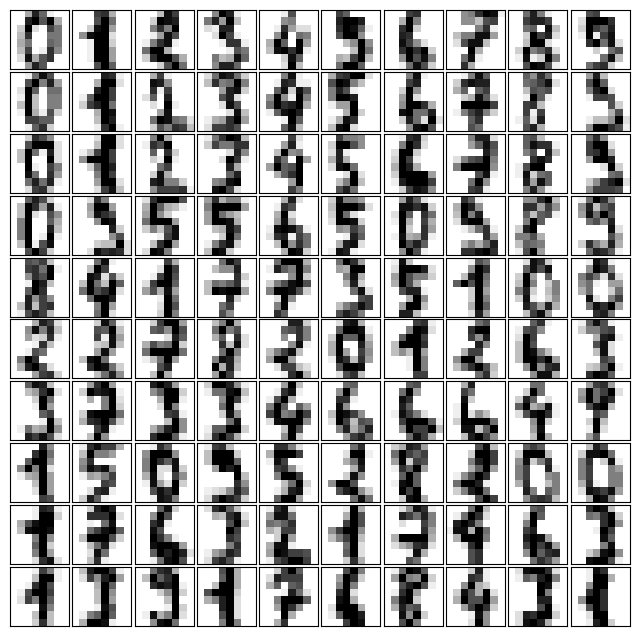

In [ ]:
# Create digit dataset
digits = load_digits()
train_dataset = DigitsDataset(digits.data[:-100])
test_dataset = DigitsDataset(digits.data[-100:])
plot_digits(digits.data)

# Normalizing flows (Affine Coupling Layer)

In [ ]:
# DO NOT CHANGE THIS CELL
class StandardLogistic(torch.distributions.Distribution):
    """Standard logistic distribution.
    """
    def __init__(self):
        super(StandardLogistic, self).__init__(validate_args=False)

    def log_prob(self, x):
        """Computes data log-likelihood.
        Args:
            x: input tensor.
        Returns:
            log-likelihood.
        """
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        """Samples from the distribution.
        Args:
            size: number of samples to generate.
        Returns:
            samples.
        """
        z = torch.distributions.Uniform(0., 1.).sample(size)
        return torch.log(z) - torch.log(1. - z)

def dequantize(x):
    '''Dequantize data.
    Add noise sampled from Uniform(0, 1) to each pixel (in [0, 16]).
    Args:
        x: input tensor.
        reverse: True in inference mode, False in training mode.
    Returns:
        dequantized data.
    '''
    noise = torch.distributions.Uniform(0., 1.).sample(x.size())
    return (x * 16. + noise) / 17.

In [ ]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, partition):
        super().__init__()
        assert partition in ["left", "right"], "Partition must be either 'left' or 'right'."
        self.partition = partition

        d = input_dim // 2
        if partition == "left":
            self._get_fixed = lambda x: x[:, :d]
            self._get_moving = lambda x: x[:, d:]
        else:
            self._get_fixed = lambda x: x[:, (input_dim - d):]
            self._get_moving = lambda x: x[:, :(input_dim - d)]

        _modules = [nn.Linear(d, hidden_dim), nn.ReLU()]
        for _ in range(num_layers):
            _modules.append(nn.Linear(hidden_dim, hidden_dim))
            _modules.append(nn.ReLU())
        _modules.append(nn.Linear(hidden_dim, (input_dim - d) * 2))
        self.conditioner = nn.Sequential(*_modules)

    def forward(self, z):
        """ z -> x"""
        fixed = self._get_fixed(z)
        updated = self._get_moving(z)

        h = self.conditioner(fixed)

        a = h[:, :h.shape[1] // 2]
        b = h[:, h.shape[1] // 2:]

        z1 = fixed
        z2 = (updated - b) * torch.exp(-a)

        if self.partition == "left":
            x = torch.cat([z1, z2], dim=1)
        else:
            x = torch.cat([z2, z1], dim=1)
        return x

    def inverse(self, x):
        """ x -> z (forward transformation) """
        fixed = self._get_fixed(x)
        updated = self._get_moving(x)

        h = self.conditioner(fixed)

        a = h[:, :h.shape[1] // 2]
        b = h[:, h.shape[1] // 2:]

        x1 = fixed
        x2 = updated * torch.exp(a) + b

        if self.partition == "left":
            z = torch.cat([x1, x2], dim=1)
        else:
            z = torch.cat([x2, x1], dim=1)

        log_det_jacobian = torch.sum(a, dim=1)
        return z, log_det_jacobian

In [ ]:
class NF(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_coupling_layers, prior):
        super().__init__()
        self.input_dim = input_dim
        self.num_coupling_layers = num_coupling_layers

        self.coupling_layers = nn.ModuleList()
        for i in range(num_coupling_layers):
            partition = "left" if i % 2 == 0 else "right"
            self.coupling_layers.append(AffineCouplingLayer(input_dim, hidden_dim, num_layers, partition))

        self.prior = prior
        self.register_buffer('_dummy', torch.empty([0, ]))

    def forward(self, z):
        with torch.no_grad():
            x = z # Initialize x with z
            for layer in reversed(self.coupling_layers):
                x = layer.forward(x)
        return x

    def inverse(self, x):
        log_det_jacobian_sum = torch.zeros(x.shape[0], device=self._dummy.device)
        z = x # Initialize z with x
        for layer in self.coupling_layers:
            z, log_det_jacobian = layer.inverse(z) # Pass z instead of x
            log_det_jacobian_sum += log_det_jacobian
        # log_det_jacobian_sum += self.scale.sum() # This line caused the error and should be removed.
        return z, log_det_jacobian_sum

    def log_prob(self, x):
        z, log_det_jacobian = self.inverse(x)
        log_p = torch.sum(self.prior.log_prob(z), dim=1) + log_det_jacobian
        return log_p

    def sample(self, num_samples):
        z = self.prior.sample((num_samples, self.input_dim)).to(self._dummy.device)
        x = self.forward(z)
        return x

In [ ]:
# DO NOT CHANGE THIS CELL
BATCH_SIZE = 128
INPUT_DIM = 64
HIDDEN_DIM = 256
NUM_LAYERS = 3
NUM_COUPLING_LAYERS = 5
MAX_ITERS = 10000

dataset_mean = torch.from_numpy((digits.data[:-100] / 16).mean(0, keepdims=True).astype(np.float32))
train_loader = inf_iterator(DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
prior = StandardLogistic()
nf_ckpt_fn = 'model_nf.pt'

# Re-run training if the model file does not exist
if not os.path.exists(nf_ckpt_fn):
    model_nf = NF(INPUT_DIM, HIDDEN_DIM, num_layers=NUM_LAYERS, num_coupling_layers=NUM_COUPLING_LAYERS, prior=prior)
    train_op = optim.Adam(model_nf.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-4)

    model_nf.train()
    for i in tqdm(range(1, MAX_ITERS + 1)):
        batch = next(train_loader)
        batch = dequantize(batch)
        batch = batch - dataset_mean

        log_p = model_nf.log_prob(batch)
        loss = -log_p.mean()

        train_op.zero_grad()
        loss.backward()
        train_op.step()
        if i % 1000 == 0:
            bit_per_dim = (loss + np.log(16.) * INPUT_DIM) / (INPUT_DIM * np.log(2.))
            with torch.no_grad():
                all_losses = []
                for batch in test_loader:
                    batch = dequantize(batch)
                    batch = batch - dataset_mean
                    log_p = model_nf.log_prob(batch)
                    all_losses.append(-log_p)
                all_losses = torch.cat(all_losses)
                test_loss = torch.mean(all_losses)
            print(f'iter: {i} loss: {loss:.4f} bits/dim = {bit_per_dim:.4f} test loss: {test_loss:.4f}')
    torch.save(model_nf.state_dict(), nf_ckpt_fn)
else:
    # If model exists, load it
    model_nf = NF(INPUT_DIM, HIDDEN_DIM, num_layers=NUM_LAYERS, num_coupling_layers=NUM_COUPLING_LAYERS, prior=prior)
    model_nf.load_state_dict(torch.load(nf_ckpt_fn))
    model_nf.eval()

  0%|          | 0/10000 [00:00<?, ?it/s]

iter: 1000 loss: -64.5993 bits/dim = 2.5438 test loss: -56.7673
iter: 2000 loss: -73.6555 bits/dim = 2.3396 test loss: -60.3655
iter: 3000 loss: -78.4312 bits/dim = 2.2320 test loss: -57.8314
iter: 4000 loss: -81.9029 bits/dim = 2.1537 test loss: -59.1373
iter: 5000 loss: -80.9551 bits/dim = 2.1751 test loss: -58.0852
iter: 6000 loss: -84.5308 bits/dim = 2.0945 test loss: -57.1957
iter: 7000 loss: -86.7025 bits/dim = 2.0455 test loss: -55.7866
iter: 8000 loss: -87.6437 bits/dim = 2.0243 test loss: -48.1905
iter: 9000 loss: -88.4275 bits/dim = 2.0067 test loss: -52.0907
iter: 10000 loss: -88.2235 bits/dim = 2.0113 test loss: -48.6955


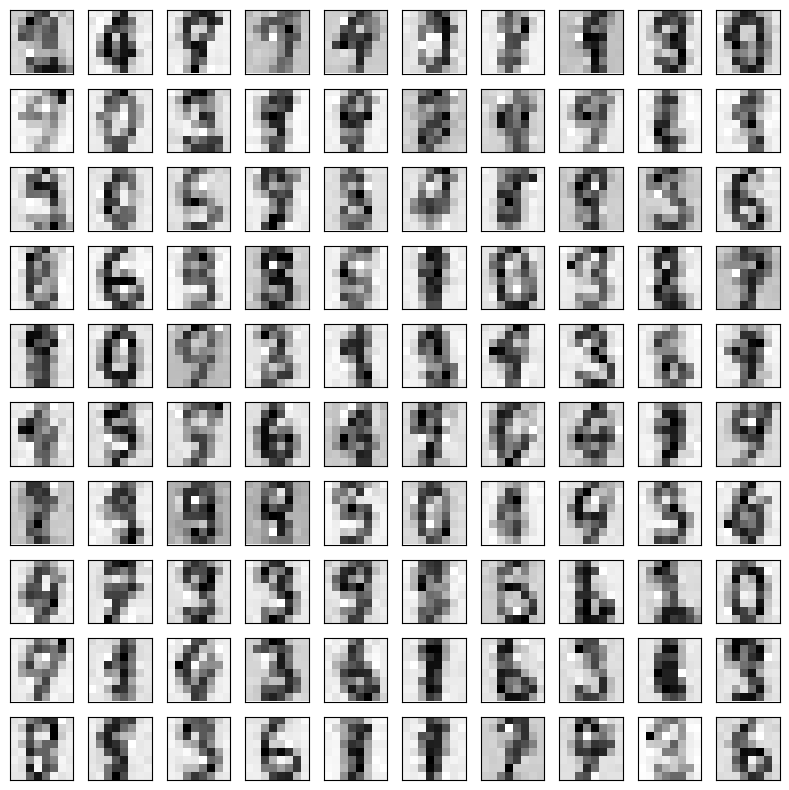

In [ ]:
model_nf.eval()
with torch.no_grad():
    samples = model_nf.sample(100).cpu()
samples += dataset_mean
plot_digits(samples)
plt.tight_layout()
plt.show()